In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from tqdm import tqdm
import re

from collections import Counter
from collections import defaultdict

from catboost import CatBoostRegressor, Pool
from scipy.stats import normaltest

import optuna
from optuna.samplers import TPESampler


from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train_result = pd.read_csv('data/df_train_result_from_eda_2.csv')

In [3]:

def safe_literal_eval(x):
    if isinstance(x, list):
        return x 
    elif isinstance(x, str):
        try:
            return literal_eval(x)
        except:
            return np.nan
    else:
        return np.nan


In [4]:
df_train_result['clustered_skills'] = df_train_result['clustered_skills'].apply(safe_literal_eval)


In [5]:
df_train_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17398 entries, 0 to 17397
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       17398 non-null  int64  
 1   salary from                      17398 non-null  float64
 2   salary to                        17398 non-null  float64
 3   position                         17398 non-null  object 
 4   experience                       17398 non-null  object 
 5   skills                           17398 non-null  object 
 6   schedule                         17398 non-null  object 
 7   employment                       17398 non-null  object 
 8   vacancy                          17398 non-null  object 
 9   level                            17398 non-null  object 
 10  region                           17398 non-null  object 
 11  mapped_skills                    17398 non-null  object 
 12  anchors_list      

In [ ]:

def filtered_skills_top_n(df_train_result, n):
    """
    Фильтрует навыки, оставляя только N наиболее популярных навыков для каждой позиции.
    
    :param df_skills_filtered: Входящий DataFrame с колонками 'position' и 'skills'.
    :param n: Число наиболее популярных навыков, которое нужно оставить.
    :return: Отфильтрованный DataFrame с сокращённым списком навыков.
    """
    
    result_df = df_train_result.copy()
    #display(result_df['skills'])
    # Перебираем каждую уникальную должность
    for pos in result_df['position'].unique():
        # Маска для выбора строк с нужной должностью
        mask = result_df['position'] == pos
        
        # Собираем все навыки в один большой список
        skills_lists = result_df.loc[mask, 'clustered_skills']
        all_skills = [skill for sublist in skills_lists for skill in sublist]
        
        # Считаем частоту появления каждого навыка
        skill_counts = Counter(all_skills)
        
        # Берём топ-n навыков
        top_n_skills = set([skill for skill, _ in skill_counts.most_common(n)])
        
        # Применяем фильтр к списку навыков
        result_df.loc[mask, 'clustered_skills'] = skills_lists.apply(
            lambda skill_list: [s for s in skill_list if s in top_n_skills]
        )
        #display(result_df['skills'])
    return result_df
from scipy.stats import normaltest



In [9]:
# Функция очистки и нормализации
def process_series(series, colname, position):
    series = pd.to_numeric(series, errors='coerce')
    series = series.dropna()
    n_total = len(series)


    stat, p = normaltest(series)
    is_normal = p > 0.05

    if is_normal:
        mu, sigma = series.mean(), series.std()
        mask = (series >= mu - 3 * sigma) & (series <= mu + 3 * sigma)
    else:
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        mask = (series >= q1 - 1.5 * iqr) & (series <= q3 + 1.5 * iqr)

    n_filtered = mask.sum()
    n_removed = n_total - n_filtered


    return series[mask]

Top-N Skills:   0%|          | 0/4 [00:00<?, ?it/s]

' Взяли 30 скилов . Осталось 16881 cтрок в df. Всего уникальных 704'

0:	learn: 41019.8152478	test: 39412.3777049	best: 39412.3777049 (0)	total: 34.7ms	remaining: 34.7s
100:	learn: 21365.9230749	test: 21909.1943677	best: 21909.1943677 (100)	total: 3.13s	remaining: 27.9s
200:	learn: 20783.9926448	test: 21811.2215210	best: 21811.2215210 (200)	total: 5.58s	remaining: 22.2s
300:	learn: 20380.5416013	test: 21722.6656141	best: 21721.8763579 (298)	total: 7.99s	remaining: 18.6s
400:	learn: 20122.0941840	test: 21678.9523654	best: 21676.1172975 (391)	total: 10.5s	remaining: 15.7s
500:	learn: 19896.6368899	test: 21658.6562350	best: 21652.4903330 (467)	total: 12.9s	remaining: 12.8s
600:	learn: 19681.0750438	test: 21617.1441761	best: 21609.8595906 (588)	total: 15.4s	remaining: 10.2s
700:	learn: 19461.3595686	test: 21578.9171183	best: 21576.8522819 (687)	total: 17.9s	remaining: 7.62s
800:	learn: 19331.1331265	test: 21580.8712423	best: 21575.2871036 (725)	total: 20.3s	remaining: 5.04s
900:	learn: 19140.7817782	test: 21557.4132702	best: 21555.6237889 (887)	total: 22.9s	

Top-N Skills:  25%|██▌       | 1/4 [01:43<05:11, 103.71s/it]

' Взяли 50 скилов . Осталось 17189 cтрок в df. Всего уникальных 1048'

0:	learn: 40712.2494141	test: 40080.9401725	best: 40080.9401725 (0)	total: 33ms	remaining: 33s
100:	learn: 21145.7540264	test: 21862.8954267	best: 21862.8954267 (100)	total: 2.98s	remaining: 26.6s
200:	learn: 20454.2071483	test: 21584.1204499	best: 21581.8319360 (199)	total: 5.26s	remaining: 20.9s
300:	learn: 20078.1954021	test: 21455.8588782	best: 21453.0946090 (298)	total: 7.54s	remaining: 17.5s
400:	learn: 19937.3658741	test: 21434.7311725	best: 21428.6940716 (352)	total: 9.64s	remaining: 14.4s
500:	learn: 19725.1104139	test: 21415.2454107	best: 21413.4387585 (452)	total: 11.9s	remaining: 11.8s
600:	learn: 19598.9184716	test: 21390.6391779	best: 21389.5602337 (599)	total: 13.9s	remaining: 9.21s
700:	learn: 19430.2909469	test: 21361.1977129	best: 21358.7265790 (666)	total: 16.1s	remaining: 6.87s
800:	learn: 19304.6244807	test: 21350.2321417	best: 21348.7319664 (794)	total: 18.2s	remaining: 4.53s
900:	learn: 19099.1485472	test: 21337.8890374	best: 21324.0974069 (844)	total: 20.5s	rema

Top-N Skills:  50%|█████     | 2/4 [03:21<03:20, 100.49s/it]

' Взяли 70 скилов . Осталось 17296 cтрок в df. Всего уникальных 1277'

0:	learn: 40643.0419938	test: 39981.3959347	best: 39981.3959347 (0)	total: 29ms	remaining: 29s
100:	learn: 21502.3373806	test: 22064.3579061	best: 22064.1015833 (99)	total: 2.71s	remaining: 24.1s
200:	learn: 20781.7749822	test: 21675.2614377	best: 21673.1154410 (199)	total: 4.91s	remaining: 19.5s
300:	learn: 20424.6343197	test: 21623.5782670	best: 21614.2874180 (286)	total: 7.03s	remaining: 16.3s
400:	learn: 20202.1754281	test: 21638.6428364	best: 21614.2874180 (286)	total: 9.08s	remaining: 13.6s
500:	learn: 19987.7598161	test: 21612.0766859	best: 21611.2035906 (495)	total: 11.1s	remaining: 11.1s
600:	learn: 19852.9988443	test: 21593.4953789	best: 21590.8078504 (588)	total: 13.1s	remaining: 8.71s
700:	learn: 19611.6249143	test: 21529.5373369	best: 21521.9562409 (671)	total: 15.2s	remaining: 6.5s
800:	learn: 19391.0340068	test: 21484.5690254	best: 21476.2043910 (779)	total: 17.5s	remaining: 4.35s
900:	learn: 19138.7812305	test: 21420.0089151	best: 21420.0089151 (900)	total: 19.8s	remain

Top-N Skills:  75%|███████▌  | 3/4 [05:00<01:39, 99.41s/it] 

' Взяли 100 скилов . Осталось 17349 cтрок в df. Всего уникальных 1539'

0:	learn: 40716.8447931	test: 39398.1167052	best: 39398.1167052 (0)	total: 70.9ms	remaining: 1m 10s
100:	learn: 21245.0558025	test: 22282.4547460	best: 22282.4547460 (100)	total: 3.08s	remaining: 27.4s
200:	learn: 20563.4358980	test: 22107.7689843	best: 22106.3014552 (196)	total: 5.41s	remaining: 21.5s
300:	learn: 20159.8100011	test: 22051.1578528	best: 22048.1398415 (296)	total: 7.68s	remaining: 17.8s
400:	learn: 19843.7563727	test: 21976.1480337	best: 21974.2097116 (397)	total: 10s	remaining: 15s
500:	learn: 19570.0213190	test: 21915.6655166	best: 21913.3023076 (495)	total: 12.2s	remaining: 12.2s
600:	learn: 19419.3144556	test: 21899.4671484	best: 21893.2997428 (584)	total: 14.3s	remaining: 9.5s
700:	learn: 19305.3422571	test: 21869.8175226	best: 21867.9723340 (676)	total: 16.4s	remaining: 6.99s
800:	learn: 19242.8527083	test: 21851.7628992	best: 21851.7628992 (800)	total: 18.6s	remaining: 4.62s
900:	learn: 19163.8421039	test: 21842.4548783	best: 21842.3600380 (898)	total: 20.6s	rema

Top-N Skills: 100%|██████████| 4/4 [06:38<00:00, 99.50s/it]


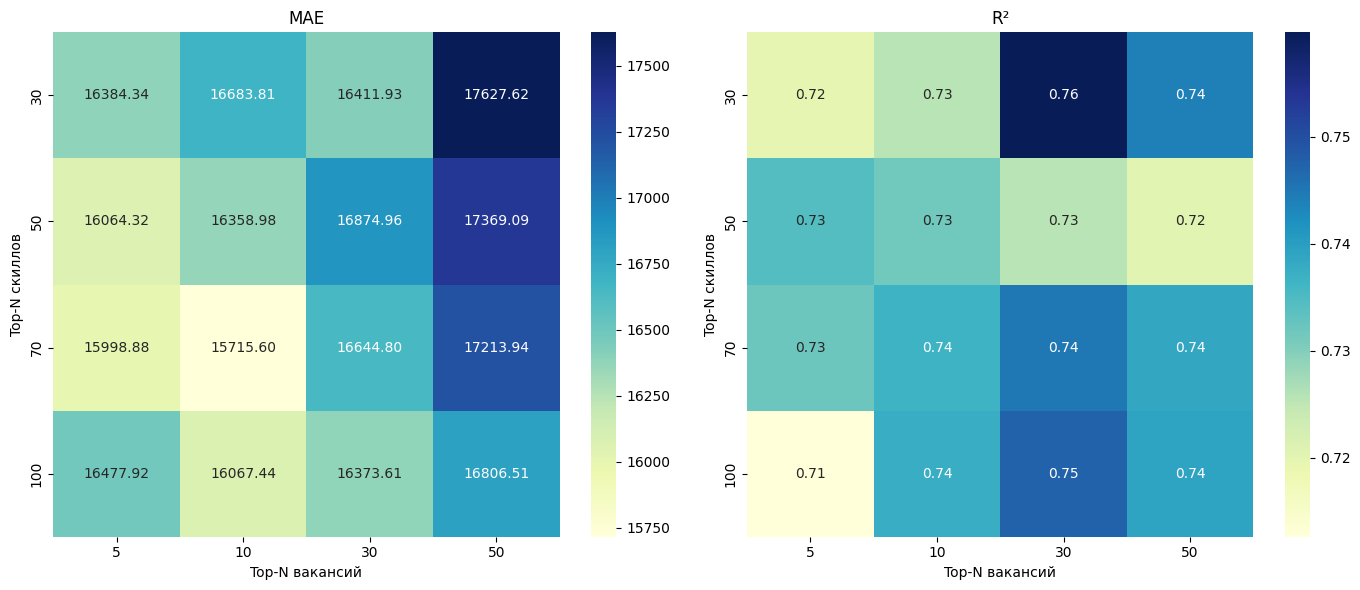

Лучшее сочетание по MAE:
Top Skills: 70.0, Top Vacancies: 10.0, MAE: 15715.60, R²: 0.74


In [21]:

import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message='DataFrameGroupBy.apply operated on the grouping columns.')

# Параметры
top_skills_range = [ 30, 50, 70, 100]
top_vacancies_range = [5,10, 30, 50] 
# Список позиций, которые оставляем

allowed_positions2 = [
    "Аналитик",
    "Бизнес-аналитик",
    "Дата-сайентист",
    "Дизайнер, художник",
    "Программист, разработчик",
    "Продуктовый аналитик",
    "Руководитель проектов",
    "Сетевой инженер",
    "Системный администратор",
    "Системный аналитик",
    "Специалист по информационной безопасности",
    "Специалист технической поддержки",
    "Технический писатель",
    'Тестировщик',
    'Менеджер продукта',
    'Системный инженер',
    'BI-аналитик, аналитик данных',
    'Методолог',
    'Руководитель группы разработки'

]




allowed_positions = [
    "Аналитик",
    "Бизнес-аналитик",
    #"Дата-сайентист",
    "Дизайнер, художник",
    #"Программист, разработчик",
    "Продуктовый аналитик",
    "Руководитель проектов",
    "Сетевой инженер",
    "Системный администратор",
    #"Системный аналитик",
    "Специалист по информационной безопасности",
    "Специалист технической поддержки",
    "Технический писатель"
]

results = []

for skill_n in tqdm(top_skills_range, desc="Top-N Skills"):
    df_skills_filtered = filtered_skills_top_n(df_train_result.copy(), skill_n)
    #display(df_skills_filtered['skills'])
    # Удаляем строки с пустыми списками skills
    df_skills_filtered = df_skills_filtered[df_skills_filtered['clustered_skills'].apply(lambda x: len(x) > 0)]
    

    def flatten_skills(skills_series):
        all_skills = []
        for skill_list in skills_series:
            if isinstance(skill_list, list):
                all_skills.extend(skill_list)
        return all_skills
    #display(df_skills_filtered['skills'])
    display(f" Взяли {skill_n} скилов . Осталось {df_skills_filtered.shape[0]} cтрок в df. Всего уникальных {len(set(flatten_skills(df_skills_filtered['clustered_skills'])))}" )
    for vac_n in top_vacancies_range:
        # Фильтрация вакансий по top-N внутри позиции
        def filter_top_vacancies(group, n=vac_n):
            vac_counts = group['vacancy_clustered'].value_counts()
            top_vacancies = vac_counts.head(n).index.tolist()
            #top_vacancies = vac_counts.index.tolist()
            return group[group['vacancy_clustered'].isin(top_vacancies)]
        


        df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)
        df_filtered = df_filtered[df_filtered['position'].isin(allowed_positions)]

        
        
        
        # Обработка целевой переменной и признаков
        df_temp = df_filtered.copy()
        
        
        # Очистка целевой переменной от выбросов
        positions_temp = df_temp['position'].dropna().unique()

        for pos in positions_temp:
            pos_mask = df_temp['position'] == pos
            clean_series = process_series(df_temp.loc[pos_mask, 'salary from'], 'salary from', pos)
            if clean_series is not None:
                df_temp.loc[clean_series.index, 'salary from norm'] = clean_series

        # Удалим строки с NaN после очистки
        df_temp = df_temp.dropna(subset=['salary from norm'])
        
        
        if df_temp.empty:
            continue



        # 1. Подготовка данных
        y = df_temp['salary from norm']

        if df_temp.empty:
            continue
        # Определяем порядковое кодирование для experience и level
        experience_order = {
            'Нет опыта': 0,
            '1–3 года': 1,
            '3–6 лет': 2,
            'Более 6 лет': 3,
            'Unknown': -1  # или np.nan для пропусков
        }

        level_order = {
            'Trainee': 0,
            'Junior': 1,
            'Middle': 2,
            'Senior': 3,
            'Lead': 4,
            'Chief': 5,
            'Unknown': -1  # или np.nan для пропусков
        }
        
        # Применяем порядковое кодирование
        df_temp['experience_ord'] = df_temp['experience'].map(experience_order) #.astype(str)
        df_temp['level_ord'] = df_temp['level'].map(level_order) #.astype(str)
        
        
        
        # Преобразование skills в строки с явным указанием типа
        df_temp['skills_str'] = df_temp['clustered_skills'].apply(
            lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x)
        )

        # 2. Формирование признаков
        features = ['position', 'experience_ord', 'schedule', 'employment', 'level_ord', 'vacancy_clustered', 'skills_str', 'region']
        X = df_temp[features]

        # 3. Указываем типы признаков
        cat_features = ['position', 'experience_ord', 'schedule', 'employment', 'level_ord', 'vacancy_clustered', 'region']
        text_features = ['skills_str']

        # 4. Разбиение на train/test
        try:
            splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            for train_idx, test_idx in splitter.split(X, df_temp['position']):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                # 5. Создаем Pool с минимальными параметрами
                train_pool = Pool(
                    data=X_train,
                    label=y_train,
                    cat_features=cat_features,
                    text_features=text_features
                )
                
                test_pool = Pool(
                    data=X_test,
                    label=y_test,
                    cat_features=cat_features,
                    text_features=text_features
                )

        except ValueError as e:
            print(f"Ошибка split при skill_n={skill_n}, vac_n={vac_n}: {e}")
            continue

        # 6. Упрощенная модель без сложной обработки текста
        model = CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=6,
            task_type='GPU',
            verbose=100
        )

        # 7. Обучение с базовыми параметрами
        model.fit(train_pool, eval_set=test_pool)

        y_pred = model.predict(X_test)
        
        
        #y_pred = np.expm1(y_pred)
        
        #mae = mean_absolute_error(np.expm1(y_test), y_pred)
        #r2 = r2_score(np.expm1(y_test),  y_pred)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test,  y_pred)

        results.append({
            'top_skills': skill_n,
            'top_vacancies': vac_n,
            'mae': mae,
            'r2': r2,
            'rows': len(df_temp)
        })

# Переводим результаты в DataFrame
results_df = pd.DataFrame(results)

# Визуализация результатов
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pivot_mae = results_df.pivot(index='top_skills', columns='top_vacancies', values='mae')
sns.heatmap(pivot_mae, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('MAE')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.subplot(1, 2, 2)
pivot_r2 = results_df.pivot(index='top_skills', columns='top_vacancies', values='r2')
sns.heatmap(pivot_r2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('R²')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.tight_layout()
plt.show()

# Вывод лучшего сочетания
best_row = results_df.sort_values(by='mae').iloc[0]
print(f"Лучшее сочетание по MAE:\nTop Skills: {best_row['top_skills']}, "
      f"Top Vacancies: {best_row['top_vacancies']}, "
      f"MAE: {best_row['mae']:.2f}, R²: {best_row['r2']:.2f}")





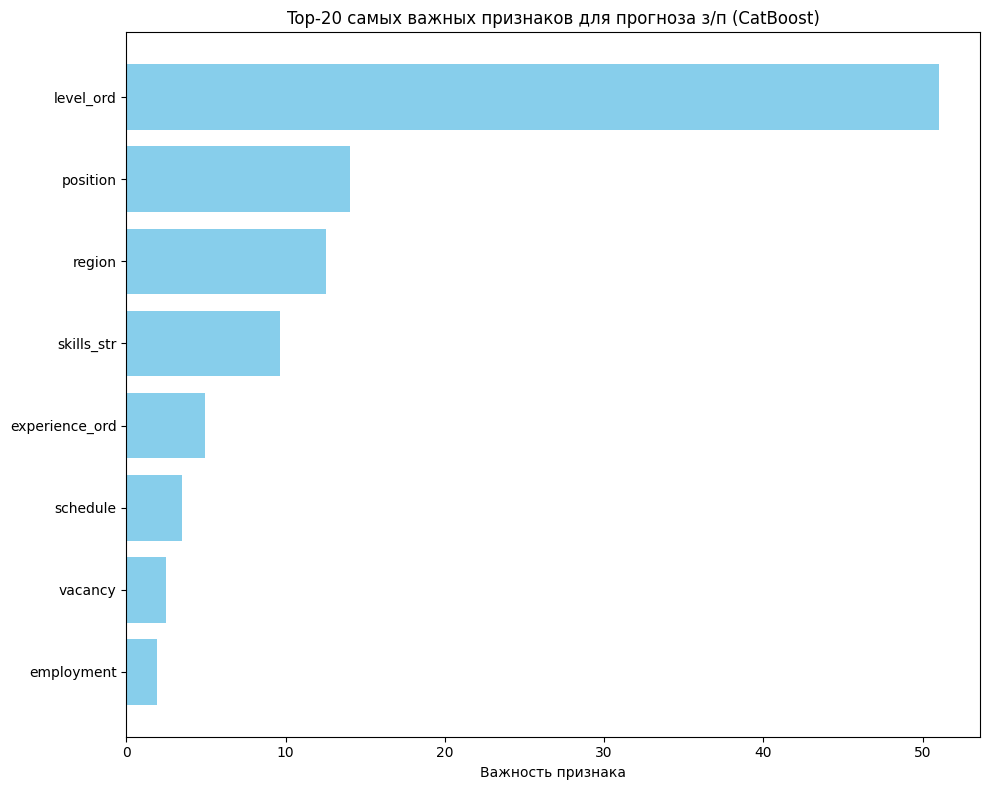

In [20]:
# Получаем важность признаков
feature_importance = model.get_feature_importance()
# Сортируем и получаем топ-20
indices = np.argsort(feature_importance)[::-1][:20]
names = [features[i] for i in indices]
scores = [feature_importance[i] for i in indices]

# Создаем горизонтальный bar plot
plt.figure(figsize=(10, 8))
plt.barh(range(len(names)), scores, align='center', color='skyblue')
plt.yticks(range(len(names)), names)
plt.xlabel('Важность признака')
plt.title('Top-20 самых важных признаков для прогноза з/п (CatBoost)')
# Важный момент: инвертируем ось Y, чтобы самый важный признак был сверху
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()